# **RNN**

Berikut adalah kumpulan kode yang digunakan untuk melakukan berbagai _test case_ pada bagian RNN.

In [46]:
# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Dense, TextVectorization, Embedding, Dropout, SimpleRNN, Input, Bidirectional
from keras.optimizers import Adam
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import F1Score

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

In [47]:
# Plotter function
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [48]:
# Dataset
train_text = pd.read_csv('train.csv').drop(columns=['id'])
valid_text = pd.read_csv('valid.csv').drop(columns=['id'])
test_text = pd.read_csv('test.csv').drop(columns=['id'])

## **EDA**

In [49]:
train_text.head()

,text,label
0,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,Ibu pernah bekerja di grab indonesia,neutral
3,Paling suka banget makan siang di sini ayam sa...,positive
4,Pelayanan bus DAMRI sangat baik,positive


In [50]:
train_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    500 non-null    object
 1   label   500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


In [51]:
print("Missing values in train text:", train_text['text'].isnull().sum())
print("Missing values in valid text:", valid_text['text'].isnull().sum())
print("Missing values in test text:", test_text['text'].isnull().sum())

print("Missing values in train label:", train_text['label'].isna().sum())
print("Missing values in valid label:", valid_text['label'].isna().sum())
print("Missing values in test label:", test_text['label'].isna().sum())

Missing values in train text: 0
Missing values in valid text: 0
Missing values in test text: 0
Missing values in train label: 0
Missing values in valid label: 0
Missing values in test label: 0


## **Data Preprocessing**

In [52]:
# Preprocessing
train_text['text'] = train_text['text'].astype(str)
valid_text['text'] = valid_text['text'].astype(str)
test_text['text'] = test_text['text'].astype(str)

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train_text['label'] = train_text['label'].map(label_map).astype('int32')
valid_text['label'] = valid_text['label'].map(label_map).astype('int32')
test_text['label'] = test_text['label'].map(label_map).astype('int32')

X_train = train_text['text']
y_train = train_text['label']
X_valid = valid_text['text']
y_valid = valid_text['label']
X_test = test_text['text']
y_test = test_text['label']

In [53]:
# Text Vectorization
vectorize_layer = TextVectorization()
vectorize_layer.adapt(train_text['text'])

In [54]:
early_stopping_callback = EarlyStopping(
        monitor='val_f1_score',
        patience=3,
        mode='max',
        restore_best_weights=True
    )

## **Percobaan**

### **Pengaruh Jumlah Layer**

#### **Variasi 1**

In [55]:
# Variasi 1 - 1 Layer RNN
model_layer_1 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            SimpleRNN(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_layer_1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, None, 64)       │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,187 (723.39 KB)

 Trainable params: 185,187 (723.39 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model_layer_1.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_layer_1 = model_layer_1.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - f1_score_macro: 0.4843 - loss: 1.1045 - val_f1_score_macro: 0.4233 - val_loss: 1.0830
Epoch 2/50
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - f1_score_macro: 0.4410 - loss: 1.0169

C:\Users\Zaki\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_f1_score` which is not available. Available metrics are: f1_score_macro,loss,val_f1_score_macro,val_loss
  current = self.get_monitor_value(logs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1_score_macro: 0.4433 - loss: 1.0134 - val_f1_score_macro: 0.4208 - val_loss: 1.0235
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score_macro: 0.4485 - loss: 0.8790 - val_f1_score_macro: 0.4734 - val_loss: 0.9714
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1_score_macro: 0.4692 - loss: 0.7153 - val_f1_score_macro: 0.4638 - val_loss: 0.9112
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score_macro: 0.4805 - loss: 0.6052 - val_f1_score_macro: 0.4731 - val_loss: 0.9214
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4816 - loss: 0.4398 - val_f1_score_macro: 0.4725 - val_loss: 0.9098
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4922 - loss: 0.3193 - val_f1_score_macro: 0.4867 - val_loss: 0.9434
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score_macro: 0.4892 - loss: 0.2954 - val_f1_score_macro: 0.4865 - val_loss: 0.9218
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 

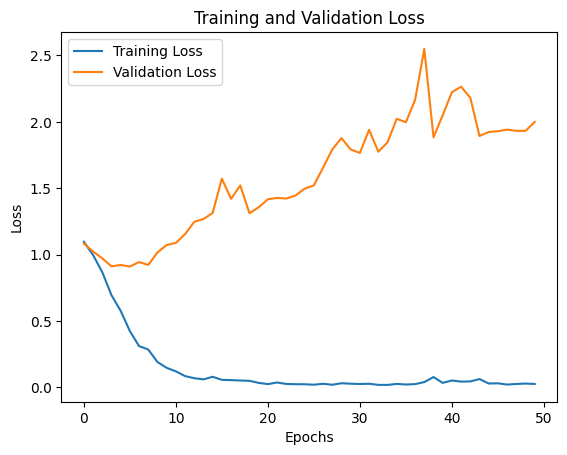

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score_macro: 0.4788 - loss: 2.0451 


[2.037837028503418, 0.4745664596557617]

In [57]:
plot_history(history_layer_1)

model_layer_1.evaluate(X_test.values, y_test)

#### **Variasi 2**

In [58]:
# Variasi 2 - 2 Layer RNN
model_layer_2 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            SimpleRNN(32, return_sequences=True),
            SimpleRNN(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_layer_2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, None, 64)       │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, None, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,267 (731.51 KB)

 Trainable params: 187,267 (731.51 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model_layer_2.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_layer_2 = model_layer_2.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - f1_score_macro: 0.4423 - loss: 1.0812 - val_f1_score_macro: 0.4223 - val_loss: 1.0845
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score_macro: 0.4479 - loss: 0.9375 - val_f1_score_macro: 0.4300 - val_loss: 1.0569
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4615 - loss: 0.8314 - val_f1_score_macro: 0.4297 - val_loss: 1.0355
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4585 - loss: 0.6569 - val_f1_score_macro: 0.4366 - val_loss: 0.9871
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score_macro: 0.4599 - loss: 0.5039 - val_f1_score_macro: 0.4459 - val_loss: 0.9826
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1_score_macro: 0.4746 - loss: 0.3916 - val_f1_score_macro: 0.4536 - val_loss: 1.0282
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4854 - loss: 0.3037 - val_f1_score_macro: 0.4670 - val_loss: 1.0250
Epoch 8/50
16/16 ━━━━━━━━━━

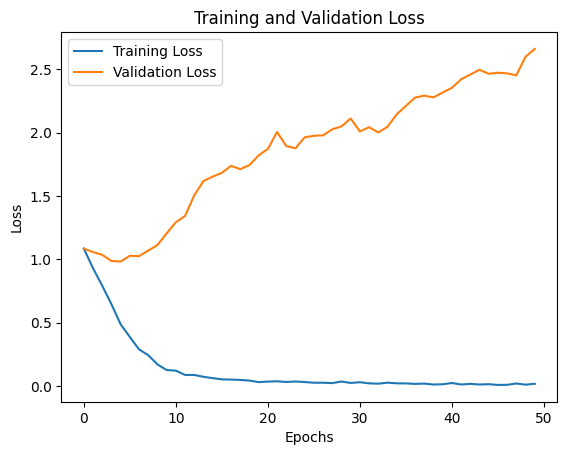

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score_macro: 0.4877 - loss: 2.7527


[2.6792526245117188, 0.485113263130188]

In [60]:
plot_history(history_layer_2)

model_layer_2.evaluate(X_test.values, y_test)

#### **Variasi 3**

In [61]:
# Variasi 3 - 3 Layer RNN
model_layer_3 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            SimpleRNN(32, return_sequences=True),
            SimpleRNN(32, return_sequences=True),
            SimpleRNN(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_layer_3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, None, 64)       │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, None, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,347 (739.64 KB)

 Trainable params: 189,347 (739.64 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model_layer_3.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_layer_3 = model_layer_3.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - f1_score_macro: 0.4803 - loss: 1.3354 - val_f1_score_macro: 0.4795 - val_loss: 1.1229
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4894 - loss: 1.0926 - val_f1_score_macro: 0.4024 - val_loss: 1.0812
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4962 - loss: 0.9323 - val_f1_score_macro: 0.4186 - val_loss: 1.0496
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4937 - loss: 0.9057 - val_f1_score_macro: 0.4254 - val_loss: 1.0402
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4853 - loss: 0.7203 - val_f1_score_macro: 0.4343 - val_loss: 1.0161
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4939 - loss: 0.6106 - val_f1_score_macro: 0.4638 - val_loss: 0.9968
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4911 - loss: 0.4777 - val_f1_score_macro: 0.4664 - val_loss: 1.0638
Epoch 8/50
16/16 ━━━━━━━━━━

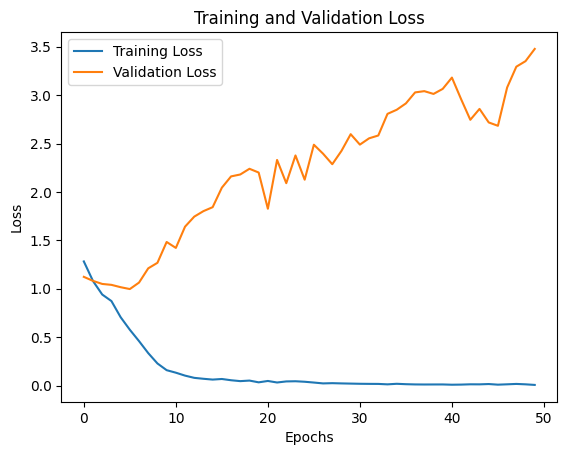

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score_macro: 0.4400 - loss: 3.6774 


[3.670985221862793, 0.4362466335296631]

In [63]:
plot_history(history_layer_3)

model_layer_3.evaluate(X_test.values, y_test)

### **Pengaruh Jumlah Cell**

#### **Variasi 1**

In [64]:
# Variasi 1
model_cell_1 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            SimpleRNN(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_cell_1.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, None, 64)       │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,187 (723.39 KB)

 Trainable params: 185,187 (723.39 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model_cell_1.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_cell_1 = model_cell_1.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - f1_score_macro: 0.4913 - loss: 1.0956 - val_f1_score_macro: 0.4564 - val_loss: 1.0797
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score_macro: 0.4894 - loss: 1.0263 - val_f1_score_macro: 0.4121 - val_loss: 1.0394
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - f1_score_macro: 0.4737 - loss: 0.9460 - val_f1_score_macro: 0.4341 - val_loss: 0.9795
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - f1_score_macro: 0.4805 - loss: 0.8676 - val_f1_score_macro: 0.4736 - val_loss: 0.9690
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score_macro: 0.4913 - loss: 0.7273 - val_f1_score_macro: 0.4720 - val_loss: 0.9698
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score_macro: 0.4936 - loss: 0.5272 - val_f1_score_macro: 0.4990 - val_loss: 0.9796
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score_macro: 0.4928 - loss: 0.3995 - val_f1_score_macro: 0.4641 - val_loss: 1.0109
Epoch 8/50
16/16 ━━━━━━━━━━━━

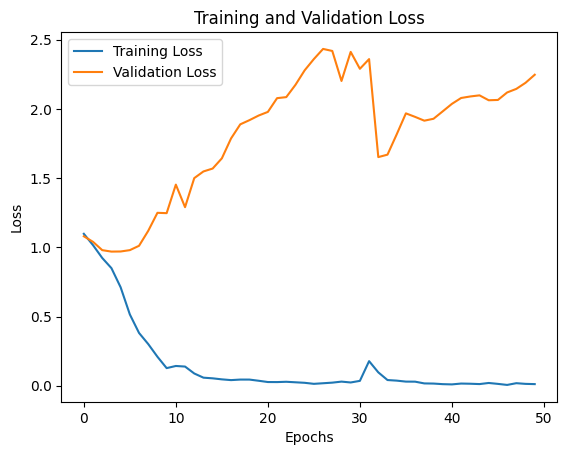

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score_macro: 0.4801 - loss: 2.4277 


[2.298931121826172, 0.47183361649513245]

In [66]:
plot_history(history_cell_1)

model_cell_1.evaluate(X_test.values, y_test)

#### **Variasi 2**

In [67]:
# Variasi 2
model_cell_2 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            SimpleRNN(64),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_cell_2.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_11 (Embedding)        │ (None, None, 64)       │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,851 (745.51 KB)

 Trainable params: 190,851 (745.51 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model_cell_2.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_cell_2 = model_cell_2.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - f1_score_macro: 0.4754 - loss: 1.0790 - val_f1_score_macro: 0.3656 - val_loss: 1.0421
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4755 - loss: 0.9657 - val_f1_score_macro: 0.3601 - val_loss: 1.0529
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4466 - loss: 0.8799 - val_f1_score_macro: 0.3983 - val_loss: 0.9854
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score_macro: 0.4787 - loss: 0.7531 - val_f1_score_macro: 0.4302 - val_loss: 0.9522
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score_macro: 0.4840 - loss: 0.6025 - val_f1_score_macro: 0.4670 - val_loss: 0.9255
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4907 - loss: 0.4110 - val_f1_score_macro: 0.4780 - val_loss: 0.9291
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4976 - loss: 0.3159 - val_f1_score_macro: 0.4249 - val_loss: 1.1930
Epoch 8/50
16/16 ━━━━━━━━━━

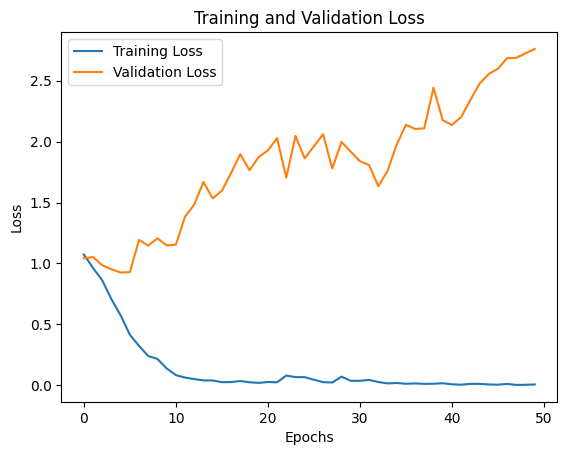

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score_macro: 0.4397 - loss: 3.0009 


[2.8644025325775146, 0.43730679154396057]

In [69]:
plot_history(history_cell_2)

model_cell_2.evaluate(X_test.values, y_test)

#### **Variasi 3**

In [70]:
# Variasi 3
model_cell_3 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            SimpleRNN(128),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_cell_3.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_12 (Embedding)        │ (None, None, 64)       │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_18 (SimpleRNN)       │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,323 (813.76 KB)

 Trainable params: 208,323 (813.76 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
model_cell_3.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_cell_3 = model_cell_3.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - f1_score_macro: 0.4452 - loss: 1.0771 - val_f1_score_macro: 0.4444 - val_loss: 1.0260
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4503 - loss: 0.9827 - val_f1_score_macro: 0.4181 - val_loss: 0.9793
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1_score_macro: 0.4471 - loss: 0.8447 - val_f1_score_macro: 0.4312 - val_loss: 1.0061
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score_macro: 0.4591 - loss: 0.7017 - val_f1_score_macro: 0.4653 - val_loss: 0.9358
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score_macro: 0.4761 - loss: 0.6223 - val_f1_score_macro: 0.4653 - val_loss: 1.1638
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score_macro: 0.4982 - loss: 0.4927 - val_f1_score_macro: 0.4769 - val_loss: 1.4211
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1_score_macro: 0.4939 - loss: 0.4454 - val_f1_score_macro: 0.4817 - val_loss: 1.5744
Epoch 8/50
16/16 ━━━━━━━━━━

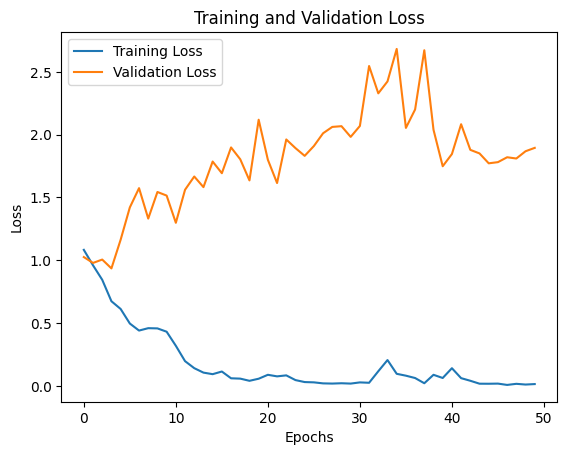

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score_macro: 0.4835 - loss: 2.6175


[2.4032368659973145, 0.4766089916229248]

In [72]:
plot_history(history_cell_3)

model_cell_3.evaluate(X_test.values, y_test)

### **Pengaruh Arah**

#### **Variasi Unidirectional**

In [73]:
# Unidirectional
model_uni = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            SimpleRNN(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_uni.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, None, 64)       │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_19 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,187 (723.39 KB)

 Trainable params: 185,187 (723.39 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
model_uni.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_uni = model_uni.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - f1_score_macro: 0.4714 - loss: 1.0824 - val_f1_score_macro: 0.4094 - val_loss: 1.0416
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score_macro: 0.4519 - loss: 0.9869 - val_f1_score_macro: 0.4370 - val_loss: 0.9784
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score_macro: 0.4661 - loss: 0.8711 - val_f1_score_macro: 0.4372 - val_loss: 0.9156
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4650 - loss: 0.7900 - val_f1_score_macro: 0.4362 - val_loss: 0.9028
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score_macro: 0.4837 - loss: 0.5792 - val_f1_score_macro: 0.4676 - val_loss: 0.8105
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - f1_score_macro: 0.4877 - loss: 0.4656 - val_f1_score_macro: 0.4580 - val_loss: 0.7964
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4954 - loss: 0.3022 - val_f1_score_macro: 0.4551 - val_loss: 0.8633
Epoch 8/50
16/16 ━━━━━━━━━━━

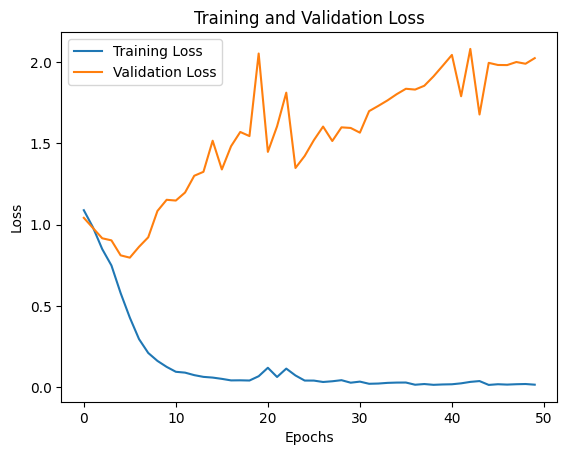

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score_macro: 0.4708 - loss: 2.4312 


[2.3096213340759277, 0.46571555733680725]

In [75]:
plot_history(history_uni)

model_uni.evaluate(X_test.values, y_test)

#### **Variasi Bidirectional**

In [76]:
# Bidirectional
model_bi = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            Bidirectional(SimpleRNN(32)),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_bi.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_14 (Embedding)        │ (None, None, 64)       │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,803 (737.51 KB)

 Trainable params: 188,803 (737.51 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model_bi.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_bi = model_bi.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - f1_score_macro: 0.4898 - loss: 1.0899 - val_f1_score_macro: 0.4417 - val_loss: 1.0449
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4664 - loss: 0.9832 - val_f1_score_macro: 0.4531 - val_loss: 0.9344
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4694 - loss: 0.7621 - val_f1_score_macro: 0.4576 - val_loss: 0.8709
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4802 - loss: 0.6739 - val_f1_score_macro: 0.4781 - val_loss: 0.8983
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4876 - loss: 0.5017 - val_f1_score_macro: 0.4693 - val_loss: 0.8297
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4872 - loss: 0.3828 - val_f1_score_macro: 0.4894 - val_loss: 0.8253
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4955 - loss: 0.2896 - val_f1_score_macro: 0.4923 - val_loss: 0.8078
Epoch 8/50
16/16 ━━━━━━━━━━

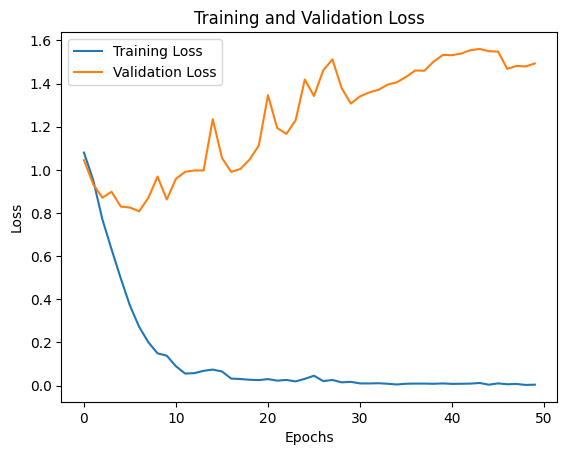

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score_macro: 0.4964 - loss: 1.6378 


[1.5264544486999512, 0.49372032284736633]

In [78]:
plot_history(history_bi)

model_bi.evaluate(X_test.values, y_test)